In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import floor
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from scipy.integrate import odeint
import scipy
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense

In [2]:
np.random.seed(0)

In [3]:
#algorithm for splitting the dataset into training and validation 
def split(X,Y,porcent): #porcent must be between 0 and 1, it is the asigned porcent to the training dataset.
    n=floor(porcent*len(X))
    index=random.sample(range(len(X)),n)
    X_learn=[]
    Y_learn=[]
    for i in index:
        X_learn.append(X[i])
        Y_learn.append(Y[i])
    X_val=np.delete(X,index, axis=0)
    Y_val=np.delete(Y,index, axis=0)
    
    X_learn=np.array(X_learn)
    Y_learn=np.array(Y_learn)
    return X_learn,Y_learn,X_val,Y_val

In [4]:
O_m=np.arange(0.1,0.51,0.1)
H_0=np.arange(66,81,0.05)
t=np.linspace(0,-12,50)

In [5]:
def RHS(Omega_i, lna, gamma=0):
    x, y, z, H = Omega_i
    #x, y, z = Omega_i
    pi = 3*x + 4*y
    return [x*(-3 + pi), y*(-4 + pi), z*pi, -0.5*H*pi]
    #return [x*(-3 + pi), y*(-4 + pi), z*pi]

def EDO(t,Om,H0):
    #t,Or,Om,Ol=X
    Or=0.0001
    Ol=1-Or-Om
    #H0 = 70.
    y0 = [Om, Or, Ol, H0]
    result = odeint(RHS, y0, t)
    return result

In [6]:
#lets generate the cartesian product between the intervals
Y0=[]
#este ciclo llena la lista fijando un Om y pasando todos los Or
for i in O_m:
    for j in H_0:
        Y0.extend(EDO(t,i,j))
Y0=np.array(Y0)

X0=[]
for Om in O_m:
    for H0 in H_0:
        for T in t:
            X0.append([T,Om,H0])
X0=np.array(X0)

In [7]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
Y2 = scaler.fit_transform(Y0)

In [8]:
#Now, here are the datasets
print('feactures= \n',X0)
print('\n')
print('labels= \n',Y2)

feactures= 
 [[  0.           0.1         66.        ]
 [ -0.24489796   0.1         66.        ]
 [ -0.48979592   0.1         66.        ]
 ...
 [-11.51020408   0.5         80.95      ]
 [-11.75510204   0.5         80.95      ]
 [-12.           0.5         80.95      ]]


labels= 
 [[9.47515373e-02 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [1.83608702e-01 1.41110961e-04 9.01997379e-01 1.60453112e-10]
 [3.22333902e-01 4.33937896e-04 7.48914062e-01 4.71545340e-10]
 ...
 [4.20164900e-02 9.58104047e-01 5.58396455e-11 3.78984027e-01]
 [3.19464665e-02 9.68145182e-01 5.73929718e-11 6.15280156e-01]
 [2.39153274e-02 9.76153281e-01 5.75118135e-11 1.00000000e+00]]


In [9]:
#Separamos los datos en validación y entrenamiento
X_learn, Y_learn, X_val, Y_val = split(X0, Y2, 0.8)



In [10]:
epochs=500
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=500,
                                   restore_best_weights=True, verbose=False)
                                   ]

In [11]:
def train_test_model(hparams, X_train, Y_train, X_test, Y_test):    
    
    # Train LSTM model and predict on validation set
    model = tf.keras.Sequential()
    model.add(Dense(int(X_train.shape[1])))
    
    for i in range(hparams['HP_LAYERS']):        
        model.add(Dense(hparams['HP_NUM_UNITS'], activation='relu'))
    model.add(Dense(4, activation='linear'))
     
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams['HP_LEARNING'], beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(
            optimizer=optimizer,
            loss='mse', 
            metrics=['mean_squared_error'])
    
    # Run with 1 epoch to speed things up for demo purposes

    train = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_test, Y_test),
              callbacks=callbacks, batch_size=hparams['HP_BATCHSIZE'], shuffle=False, verbose=True)

    _, loss = model.evaluate(X_test, Y_test)
    
    return model, loss, train.history

# Grid

- layers 2	
- nodes 150	
- lr 0.001 	
- bs 16 	


In [12]:
hparams_grid = {'HP_LAYERS': 2, 'HP_NUM_UNITS': 150, 'HP_BATCHSIZE': 16, 'HP_LEARNING':0.001}
model_grid, loss_grid, history_grid = train_test_model(hparams_grid, X_learn, Y_learn, X_val, Y_val)

Epoch 1/500
3750/3750 [==============================] - 4s 1ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 2/500
3750/3750 [==============================] - 4s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 3/500
3750/3750 [==============================] - 4s 1ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 4/500
3750/3750 [==============================] - 4s 1ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 5/500
3750/3750 [==============================] - 4s 1ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 6/500
3750/3750 [==============================] - 4s 1ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 6.2295e-04 - val_mean_squared_error: 6.2295e-04
Ep

3750/3750 [==============================] - 4s 1ms/step - loss: 1.1618e-04 - mean_squared_error: 1.1618e-04 - val_loss: 1.3890e-04 - val_mean_squared_error: 1.3890e-04
Epoch 47/500
3750/3750 [==============================] - 4s 1ms/step - loss: 1.1875e-04 - mean_squared_error: 1.1875e-04 - val_loss: 1.3348e-04 - val_mean_squared_error: 1.3348e-04
Epoch 48/500
3750/3750 [==============================] - 4s 1ms/step - loss: 1.0657e-04 - mean_squared_error: 1.0657e-04 - val_loss: 1.0731e-04 - val_mean_squared_error: 1.0731e-04
Epoch 49/500
3750/3750 [==============================] - 4s 1ms/step - loss: 1.0367e-04 - mean_squared_error: 1.0367e-04 - val_loss: 8.8277e-05 - val_mean_squared_error: 8.8277e-05
Epoch 50/500
3750/3750 [==============================] - 4s 1ms/step - loss: 1.0251e-04 - mean_squared_error: 1.0251e-04 - val_loss: 9.0578e-05 - val_mean_squared_error: 9.0578e-05
Epoch 51/500
3750/3750 [==============================] - 4s 1ms/step - loss: 1.1815e-04 - mean_squared

3750/3750 [==============================] - 4s 1ms/step - loss: 7.3568e-05 - mean_squared_error: 7.3568e-05 - val_loss: 2.2186e-05 - val_mean_squared_error: 2.2186e-05
Epoch 92/500
3750/3750 [==============================] - 4s 1ms/step - loss: 8.4225e-05 - mean_squared_error: 8.4225e-05 - val_loss: 1.6827e-05 - val_mean_squared_error: 1.6827e-05
Epoch 93/500
3750/3750 [==============================] - 4s 1ms/step - loss: 1.2468e-04 - mean_squared_error: 1.2468e-04 - val_loss: 6.8614e-05 - val_mean_squared_error: 6.8614e-05
Epoch 94/500
3750/3750 [==============================] - 4s 1ms/step - loss: 7.7106e-05 - mean_squared_error: 7.7106e-05 - val_loss: 6.0375e-05 - val_mean_squared_error: 6.0375e-05
Epoch 95/500
3750/3750 [==============================] - 4s 1ms/step - loss: 7.7867e-05 - mean_squared_error: 7.7867e-05 - val_loss: 3.4301e-05 - val_mean_squared_error: 3.4301e-05
Epoch 96/500
3750/3750 [==============================] - 4s 1ms/step - loss: 7.9229e-05 - mean_squared

Epoch 136/500
3750/3750 [==============================] - 4s 1ms/step - loss: 5.9322e-05 - mean_squared_error: 5.9322e-05 - val_loss: 1.5382e-05 - val_mean_squared_error: 1.5382e-05
Epoch 137/500
3750/3750 [==============================] - 4s 1ms/step - loss: 7.2771e-05 - mean_squared_error: 7.2771e-05 - val_loss: 2.2880e-05 - val_mean_squared_error: 2.2880e-05
Epoch 138/500
3750/3750 [==============================] - 4s 1ms/step - loss: 5.3097e-05 - mean_squared_error: 5.3097e-05 - val_loss: 1.7586e-05 - val_mean_squared_error: 1.7586e-05
Epoch 139/500
3750/3750 [==============================] - 4s 1ms/step - loss: 1.1807e-04 - mean_squared_error: 1.1807e-04 - val_loss: 6.2955e-05 - val_mean_squared_error: 6.2955e-05
Epoch 140/500
3750/3750 [==============================] - 4s 1ms/step - loss: 8.3751e-05 - mean_squared_error: 8.3751e-05 - val_loss: 5.5532e-05 - val_mean_squared_error: 5.5532e-05
Epoch 141/500
3750/3750 [==============================] - 4s 1ms/step - loss: 7.7484

Epoch 181/500
3750/3750 [==============================] - 4s 1ms/step - loss: 5.0694e-05 - mean_squared_error: 5.0694e-05 - val_loss: 2.7827e-05 - val_mean_squared_error: 2.7827e-05
Epoch 182/500
3750/3750 [==============================] - 4s 1ms/step - loss: 5.7642e-05 - mean_squared_error: 5.7642e-05 - val_loss: 2.8614e-05 - val_mean_squared_error: 2.8614e-05
Epoch 183/500
3750/3750 [==============================] - 4s 1ms/step - loss: 5.3202e-05 - mean_squared_error: 5.3202e-05 - val_loss: 1.3190e-05 - val_mean_squared_error: 1.3190e-05
Epoch 184/500
3750/3750 [==============================] - 4s 1ms/step - loss: 5.8858e-05 - mean_squared_error: 5.8858e-05 - val_loss: 1.6391e-05 - val_mean_squared_error: 1.6391e-05
Epoch 185/500
3750/3750 [==============================] - 4s 1ms/step - loss: 5.5091e-05 - mean_squared_error: 5.5091e-05 - val_loss: 7.9494e-06 - val_mean_squared_error: 7.9494e-06
Epoch 186/500
3750/3750 [==============================] - 4s 1ms/step - loss: 5.3776

Epoch 226/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.0296e-05 - mean_squared_error: 4.0296e-05 - val_loss: 1.1556e-05 - val_mean_squared_error: 1.1556e-05
Epoch 227/500
3750/3750 [==============================] - 4s 1ms/step - loss: 5.1849e-05 - mean_squared_error: 5.1849e-05 - val_loss: 1.5055e-05 - val_mean_squared_error: 1.5055e-05
Epoch 228/500
3750/3750 [==============================] - 4s 1ms/step - loss: 5.7128e-05 - mean_squared_error: 5.7128e-05 - val_loss: 3.7132e-05 - val_mean_squared_error: 3.7132e-05
Epoch 229/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.1200e-05 - mean_squared_error: 4.1200e-05 - val_loss: 3.5472e-05 - val_mean_squared_error: 3.5472e-05
Epoch 230/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.5469e-05 - mean_squared_error: 4.5469e-05 - val_loss: 1.2010e-05 - val_mean_squared_error: 1.2010e-05
Epoch 231/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.3569

Epoch 271/500
3750/3750 [==============================] - 4s 1ms/step - loss: 7.0568e-05 - mean_squared_error: 7.0568e-05 - val_loss: 4.4092e-05 - val_mean_squared_error: 4.4092e-05
Epoch 272/500
3750/3750 [==============================] - 4s 1ms/step - loss: 6.1362e-05 - mean_squared_error: 6.1362e-05 - val_loss: 3.8897e-05 - val_mean_squared_error: 3.8897e-05
Epoch 273/500
3750/3750 [==============================] - 4s 1ms/step - loss: 5.7618e-05 - mean_squared_error: 5.7618e-05 - val_loss: 6.0014e-05 - val_mean_squared_error: 6.0014e-05
Epoch 274/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.7758e-05 - mean_squared_error: 4.7758e-05 - val_loss: 3.7844e-05 - val_mean_squared_error: 3.7844e-05
Epoch 275/500
3750/3750 [==============================] - 4s 1ms/step - loss: 5.9314e-05 - mean_squared_error: 5.9314e-05 - val_loss: 5.9063e-05 - val_mean_squared_error: 5.9063e-05
Epoch 276/500
3750/3750 [==============================] - 4s 1ms/step - loss: 5.5330

Epoch 316/500
3750/3750 [==============================] - 4s 1ms/step - loss: 3.7438e-05 - mean_squared_error: 3.7438e-05 - val_loss: 4.1736e-05 - val_mean_squared_error: 4.1736e-05
Epoch 317/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.7035e-05 - mean_squared_error: 4.7035e-05 - val_loss: 1.1354e-04 - val_mean_squared_error: 1.1354e-04
Epoch 318/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.0830e-05 - mean_squared_error: 4.0830e-05 - val_loss: 3.0539e-05 - val_mean_squared_error: 3.0539e-05
Epoch 319/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.7771e-05 - mean_squared_error: 4.7771e-05 - val_loss: 1.2623e-05 - val_mean_squared_error: 1.2623e-05
Epoch 320/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.9486e-05 - mean_squared_error: 4.9486e-05 - val_loss: 3.0036e-06 - val_mean_squared_error: 3.0036e-06
Epoch 321/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.7937

Epoch 361/500
3750/3750 [==============================] - 4s 1ms/step - loss: 5.2154e-05 - mean_squared_error: 5.2154e-05 - val_loss: 2.1463e-05 - val_mean_squared_error: 2.1463e-05
Epoch 362/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.2617e-05 - mean_squared_error: 4.2617e-05 - val_loss: 2.3754e-05 - val_mean_squared_error: 2.3754e-05
Epoch 363/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.3309e-05 - mean_squared_error: 4.3309e-05 - val_loss: 1.1044e-05 - val_mean_squared_error: 1.1044e-05
Epoch 364/500
3750/3750 [==============================] - 4s 1ms/step - loss: 5.2591e-05 - mean_squared_error: 5.2591e-05 - val_loss: 3.7505e-05 - val_mean_squared_error: 3.7505e-05
Epoch 365/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.8901e-05 - mean_squared_error: 4.8901e-05 - val_loss: 3.8738e-05 - val_mean_squared_error: 3.8738e-05
Epoch 366/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.4436

Epoch 406/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.8323e-05 - mean_squared_error: 4.8323e-05 - val_loss: 2.7947e-05 - val_mean_squared_error: 2.7947e-05
Epoch 407/500
3750/3750 [==============================] - 4s 1ms/step - loss: 3.8209e-05 - mean_squared_error: 3.8209e-05 - val_loss: 1.2216e-05 - val_mean_squared_error: 1.2216e-05
Epoch 408/500
3750/3750 [==============================] - 4s 1ms/step - loss: 5.3182e-05 - mean_squared_error: 5.3182e-05 - val_loss: 3.2038e-05 - val_mean_squared_error: 3.2038e-05
Epoch 409/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.2930e-05 - mean_squared_error: 4.2930e-05 - val_loss: 2.6637e-05 - val_mean_squared_error: 2.6637e-05
Epoch 410/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.2924e-05 - mean_squared_error: 4.2924e-05 - val_loss: 2.4402e-05 - val_mean_squared_error: 2.4402e-05
Epoch 411/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.4146

Epoch 451/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.1545e-05 - mean_squared_error: 4.1545e-05 - val_loss: 2.2682e-05 - val_mean_squared_error: 2.2682e-05
Epoch 452/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.3500e-05 - mean_squared_error: 4.3500e-05 - val_loss: 4.3656e-05 - val_mean_squared_error: 4.3656e-05
Epoch 453/500
3750/3750 [==============================] - 4s 1ms/step - loss: 3.7243e-05 - mean_squared_error: 3.7243e-05 - val_loss: 7.4621e-06 - val_mean_squared_error: 7.4621e-06
Epoch 454/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.0319e-05 - mean_squared_error: 4.0319e-05 - val_loss: 1.6190e-05 - val_mean_squared_error: 1.6190e-05
Epoch 455/500
3750/3750 [==============================] - 4s 1ms/step - loss: 3.8133e-05 - mean_squared_error: 3.8133e-05 - val_loss: 9.3831e-05 - val_mean_squared_error: 9.3831e-05
Epoch 456/500
3750/3750 [==============================] - 4s 1ms/step - loss: 4.2818

Epoch 496/500
3750/3750 [==============================] - 4s 1ms/step - loss: 3.1806e-05 - mean_squared_error: 3.1806e-05 - val_loss: 1.1946e-05 - val_mean_squared_error: 1.1946e-05
Epoch 497/500
3750/3750 [==============================] - 4s 1ms/step - loss: 3.2819e-05 - mean_squared_error: 3.2819e-05 - val_loss: 1.5162e-05 - val_mean_squared_error: 1.5162e-05
Epoch 498/500
3750/3750 [==============================] - 4s 1ms/step - loss: 3.8304e-05 - mean_squared_error: 3.8304e-05 - val_loss: 2.9919e-05 - val_mean_squared_error: 2.9919e-05
Epoch 499/500
3750/3750 [==============================] - 4s 1ms/step - loss: 3.8276e-05 - mean_squared_error: 3.8276e-05 - val_loss: 1.9139e-05 - val_mean_squared_error: 1.9139e-05
Epoch 500/500
469/469 [==============================] - 0s 712us/step - loss: 1.5437e-05 - mean_squared_error: 1.5437e-05


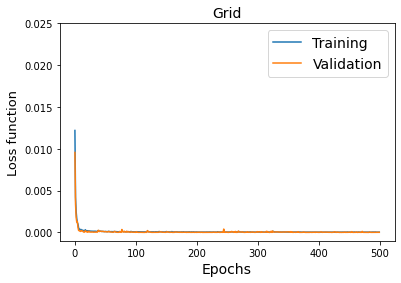

In [13]:
plt.plot(history_grid['loss'], label='Training')
plt.plot(history_grid['val_loss'], label='Validation')
plt.ylabel('Loss function', fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.title("Grid", fontsize=14)
plt.ylim(-0.001, 0.025)
plt.savefig("loss_grid_ecs.png")

In [14]:
loss_grid

1.5436669855262153e-05

In [15]:
print("epochs", len(history_grid['loss']))

epochs 500


In [16]:
model_grid.save("models/model_ecsdif_grid.h5")

# Genetic

- layers 4
- number of neurons: 100
- Batch size 8
- Learning rate: 0.0001

loss = 0.000186

<!-- 4 	100 	0.00010 	8 	0.000186 	0.000186 -->

In [17]:
hparams_gen1 = {'HP_LAYERS': 4, 'HP_NUM_UNITS': 150, 'HP_BATCHSIZE': 8, 'HP_LEARNING':0.001}
model_gen1, loss_gen1, history_gen1 = train_test_model(hparams_gen1, X_learn, Y_learn, X_val, Y_val)

Epoch 1/500
7500/7500 [==============================] - 11s 1ms/step - loss: 0.0185 - mean_squared_error: 0.0185 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 2/500
7500/7500 [==============================] - 11s 1ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 3/500
7500/7500 [==============================] - 10s 1ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 4/500
7500/7500 [==============================] - 10s 1ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 6.2585e-04 - val_mean_squared_error: 6.2585e-04
Epoch 5/500
7500/7500 [==============================] - 10s 1ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 4.7027e-04 - val_mean_squared_error: 4.7027e-04
Epoch 6/500
7500/7500 [==============================] - 10s 1ms/step - loss: 8.6899e-04 - mean_squared_error: 8.6899e-04 - val_loss: 3.5214e-04 - val_mea

7500/7500 [==============================] - 10s 1ms/step - loss: 1.6792e-04 - mean_squared_error: 1.6792e-04 - val_loss: 2.4960e-05 - val_mean_squared_error: 2.4960e-05
Epoch 47/500
7500/7500 [==============================] - 10s 1ms/step - loss: 1.6556e-04 - mean_squared_error: 1.6556e-04 - val_loss: 2.2914e-05 - val_mean_squared_error: 2.2914e-05
Epoch 48/500
7500/7500 [==============================] - 11s 1ms/step - loss: 1.5901e-04 - mean_squared_error: 1.5901e-04 - val_loss: 2.2907e-05 - val_mean_squared_error: 2.2907e-05
Epoch 49/500
7500/7500 [==============================] - 10s 1ms/step - loss: 1.8525e-04 - mean_squared_error: 1.8525e-04 - val_loss: 2.0593e-05 - val_mean_squared_error: 2.0593e-05
Epoch 50/500
7500/7500 [==============================] - 11s 1ms/step - loss: 1.8372e-04 - mean_squared_error: 1.8372e-04 - val_loss: 1.9902e-05 - val_mean_squared_error: 1.9902e-05
Epoch 51/500
7500/7500 [==============================] - 10s 1ms/step - loss: 1.5812e-04 - mean_s

Epoch 91/500
7500/7500 [==============================] - 10s 1ms/step - loss: 1.1307e-04 - mean_squared_error: 1.1307e-04 - val_loss: 1.7095e-05 - val_mean_squared_error: 1.7095e-05
Epoch 92/500
7500/7500 [==============================] - 10s 1ms/step - loss: 1.0661e-04 - mean_squared_error: 1.0661e-04 - val_loss: 1.7960e-05 - val_mean_squared_error: 1.7960e-05
Epoch 93/500
7500/7500 [==============================] - 11s 1ms/step - loss: 1.1370e-04 - mean_squared_error: 1.1370e-04 - val_loss: 1.8551e-05 - val_mean_squared_error: 1.8551e-05
Epoch 94/500
7500/7500 [==============================] - 10s 1ms/step - loss: 1.1047e-04 - mean_squared_error: 1.1047e-04 - val_loss: 1.7584e-05 - val_mean_squared_error: 1.7584e-05
Epoch 95/500
7500/7500 [==============================] - 11s 1ms/step - loss: 1.0276e-04 - mean_squared_error: 1.0276e-04 - val_loss: 1.7838e-05 - val_mean_squared_error: 1.7838e-05
Epoch 96/500
7500/7500 [==============================] - 10s 1ms/step - loss: 1.0895

7500/7500 [==============================] - 10s 1ms/step - loss: 9.2139e-05 - mean_squared_error: 9.2139e-05 - val_loss: 1.2521e-05 - val_mean_squared_error: 1.2521e-05
Epoch 136/500
7500/7500 [==============================] - 10s 1ms/step - loss: 8.5737e-05 - mean_squared_error: 8.5737e-05 - val_loss: 1.7374e-05 - val_mean_squared_error: 1.7374e-05
Epoch 137/500
7500/7500 [==============================] - 10s 1ms/step - loss: 8.5548e-05 - mean_squared_error: 8.5548e-05 - val_loss: 1.4176e-05 - val_mean_squared_error: 1.4176e-05
Epoch 138/500
7500/7500 [==============================] - 10s 1ms/step - loss: 9.5336e-05 - mean_squared_error: 9.5336e-05 - val_loss: 1.2968e-05 - val_mean_squared_error: 1.2968e-05
Epoch 139/500
7500/7500 [==============================] - 11s 1ms/step - loss: 8.4157e-05 - mean_squared_error: 8.4157e-05 - val_loss: 1.1420e-05 - val_mean_squared_error: 1.1420e-05
Epoch 140/500
7500/7500 [==============================] - 10s 1ms/step - loss: 8.4827e-05 - m

7500/7500 [==============================] - 10s 1ms/step - loss: 8.4043e-05 - mean_squared_error: 8.4043e-05 - val_loss: 9.3454e-06 - val_mean_squared_error: 9.3454e-06
Epoch 180/500
7500/7500 [==============================] - 10s 1ms/step - loss: 7.8925e-05 - mean_squared_error: 7.8925e-05 - val_loss: 3.0191e-05 - val_mean_squared_error: 3.0191e-05
Epoch 181/500
7500/7500 [==============================] - 10s 1ms/step - loss: 7.4023e-05 - mean_squared_error: 7.4023e-05 - val_loss: 8.1455e-06 - val_mean_squared_error: 8.1455e-06
Epoch 182/500
7500/7500 [==============================] - 10s 1ms/step - loss: 7.2688e-05 - mean_squared_error: 7.2688e-05 - val_loss: 8.7925e-06 - val_mean_squared_error: 8.7925e-06
Epoch 183/500
7500/7500 [==============================] - 10s 1ms/step - loss: 7.1274e-05 - mean_squared_error: 7.1274e-05 - val_loss: 8.5231e-06 - val_mean_squared_error: 8.5231e-06
Epoch 184/500
7500/7500 [==============================] - 10s 1ms/step - loss: 7.7535e-05 - m

7500/7500 [==============================] - 11s 1ms/step - loss: 7.5306e-05 - mean_squared_error: 7.5306e-05 - val_loss: 9.7897e-06 - val_mean_squared_error: 9.7897e-06
Epoch 224/500
7500/7500 [==============================] - 11s 1ms/step - loss: 6.7199e-05 - mean_squared_error: 6.7199e-05 - val_loss: 1.1328e-05 - val_mean_squared_error: 1.1328e-05
Epoch 225/500
7500/7500 [==============================] - 10s 1ms/step - loss: 7.3393e-05 - mean_squared_error: 7.3393e-05 - val_loss: 1.2151e-05 - val_mean_squared_error: 1.2151e-05
Epoch 226/500
7500/7500 [==============================] - 11s 1ms/step - loss: 6.9355e-05 - mean_squared_error: 6.9355e-05 - val_loss: 1.3035e-05 - val_mean_squared_error: 1.3035e-05
Epoch 227/500
7500/7500 [==============================] - 10s 1ms/step - loss: 7.5904e-05 - mean_squared_error: 7.5904e-05 - val_loss: 1.1464e-05 - val_mean_squared_error: 1.1464e-05
Epoch 228/500
7500/7500 [==============================] - 10s 1ms/step - loss: 7.4227e-05 - m

7500/7500 [==============================] - 10s 1ms/step - loss: 5.9535e-05 - mean_squared_error: 5.9535e-05 - val_loss: 2.2762e-05 - val_mean_squared_error: 2.2762e-05
Epoch 268/500
7500/7500 [==============================] - 10s 1ms/step - loss: 5.6929e-05 - mean_squared_error: 5.6929e-05 - val_loss: 2.1607e-05 - val_mean_squared_error: 2.1607e-05
Epoch 269/500
7500/7500 [==============================] - 10s 1ms/step - loss: 5.5397e-05 - mean_squared_error: 5.5397e-05 - val_loss: 1.2889e-05 - val_mean_squared_error: 1.2889e-05
Epoch 270/500
7500/7500 [==============================] - 10s 1ms/step - loss: 6.5385e-05 - mean_squared_error: 6.5385e-05 - val_loss: 2.6736e-05 - val_mean_squared_error: 2.6736e-05
Epoch 271/500
7500/7500 [==============================] - 10s 1ms/step - loss: 5.8797e-05 - mean_squared_error: 5.8797e-05 - val_loss: 1.1732e-05 - val_mean_squared_error: 1.1732e-05
Epoch 272/500
7500/7500 [==============================] - 11s 1ms/step - loss: 5.8872e-05 - m

7500/7500 [==============================] - 10s 1ms/step - loss: 5.2498e-05 - mean_squared_error: 5.2498e-05 - val_loss: 1.2894e-05 - val_mean_squared_error: 1.2894e-05
Epoch 312/500
7500/7500 [==============================] - 10s 1ms/step - loss: 7.5426e-05 - mean_squared_error: 7.5426e-05 - val_loss: 1.0444e-05 - val_mean_squared_error: 1.0444e-05
Epoch 313/500
7500/7500 [==============================] - 10s 1ms/step - loss: 5.5837e-05 - mean_squared_error: 5.5837e-05 - val_loss: 1.0943e-05 - val_mean_squared_error: 1.0943e-05
Epoch 314/500
7500/7500 [==============================] - 10s 1ms/step - loss: 5.2814e-05 - mean_squared_error: 5.2814e-05 - val_loss: 2.3039e-05 - val_mean_squared_error: 2.3039e-05
Epoch 315/500
7500/7500 [==============================] - 10s 1ms/step - loss: 5.2175e-05 - mean_squared_error: 5.2175e-05 - val_loss: 1.8207e-05 - val_mean_squared_error: 1.8207e-05
Epoch 316/500
7500/7500 [==============================] - 10s 1ms/step - loss: 6.6397e-05 - m

7500/7500 [==============================] - 10s 1ms/step - loss: 5.6370e-05 - mean_squared_error: 5.6370e-05 - val_loss: 3.8470e-05 - val_mean_squared_error: 3.8470e-05
Epoch 356/500
7500/7500 [==============================] - 10s 1ms/step - loss: 5.4457e-05 - mean_squared_error: 5.4457e-05 - val_loss: 1.2042e-05 - val_mean_squared_error: 1.2042e-05
Epoch 357/500
7500/7500 [==============================] - 10s 1ms/step - loss: 6.2508e-05 - mean_squared_error: 6.2508e-05 - val_loss: 1.1422e-05 - val_mean_squared_error: 1.1422e-05
Epoch 358/500
7500/7500 [==============================] - 10s 1ms/step - loss: 5.5862e-05 - mean_squared_error: 5.5862e-05 - val_loss: 9.9883e-06 - val_mean_squared_error: 9.9883e-06
Epoch 359/500
7500/7500 [==============================] - 10s 1ms/step - loss: 5.8499e-05 - mean_squared_error: 5.8499e-05 - val_loss: 1.3923e-05 - val_mean_squared_error: 1.3923e-05
Epoch 360/500
7500/7500 [==============================] - 10s 1ms/step - loss: 5.2070e-05 - m

7500/7500 [==============================] - 10s 1ms/step - loss: 4.6970e-05 - mean_squared_error: 4.6970e-05 - val_loss: 1.0121e-05 - val_mean_squared_error: 1.0121e-05
Epoch 400/500
7500/7500 [==============================] - 10s 1ms/step - loss: 7.2257e-05 - mean_squared_error: 7.2257e-05 - val_loss: 1.5322e-05 - val_mean_squared_error: 1.5322e-05
Epoch 401/500
7500/7500 [==============================] - 10s 1ms/step - loss: 7.3675e-05 - mean_squared_error: 7.3675e-05 - val_loss: 1.0179e-05 - val_mean_squared_error: 1.0179e-05
Epoch 402/500
7500/7500 [==============================] - 10s 1ms/step - loss: 5.2283e-05 - mean_squared_error: 5.2283e-05 - val_loss: 1.3236e-05 - val_mean_squared_error: 1.3236e-05
Epoch 403/500
7500/7500 [==============================] - 11s 1ms/step - loss: 4.7919e-05 - mean_squared_error: 4.7919e-05 - val_loss: 1.0773e-05 - val_mean_squared_error: 1.0773e-05
Epoch 404/500
7500/7500 [==============================] - 10s 1ms/step - loss: 5.0781e-05 - m

7500/7500 [==============================] - 11s 1ms/step - loss: 6.4917e-05 - mean_squared_error: 6.4917e-05 - val_loss: 1.5218e-05 - val_mean_squared_error: 1.5218e-05
Epoch 444/500
7500/7500 [==============================] - 10s 1ms/step - loss: 5.7956e-05 - mean_squared_error: 5.7956e-05 - val_loss: 1.2867e-05 - val_mean_squared_error: 1.2867e-05
Epoch 445/500
7500/7500 [==============================] - 11s 1ms/step - loss: 4.6266e-05 - mean_squared_error: 4.6266e-05 - val_loss: 8.8890e-06 - val_mean_squared_error: 8.8890e-06
Epoch 446/500
7500/7500 [==============================] - 10s 1ms/step - loss: 5.2179e-05 - mean_squared_error: 5.2179e-05 - val_loss: 8.9958e-06 - val_mean_squared_error: 8.9958e-06
Epoch 447/500
7500/7500 [==============================] - 10s 1ms/step - loss: 4.7682e-05 - mean_squared_error: 4.7682e-05 - val_loss: 1.0422e-05 - val_mean_squared_error: 1.0422e-05
Epoch 448/500
7500/7500 [==============================] - 10s 1ms/step - loss: 6.0778e-05 - m

7500/7500 [==============================] - 10s 1ms/step - loss: 4.4890e-05 - mean_squared_error: 4.4890e-05 - val_loss: 1.0594e-05 - val_mean_squared_error: 1.0594e-05
Epoch 488/500
7500/7500 [==============================] - 10s 1ms/step - loss: 4.5068e-05 - mean_squared_error: 4.5068e-05 - val_loss: 8.0399e-06 - val_mean_squared_error: 8.0399e-06
Epoch 489/500
7500/7500 [==============================] - 10s 1ms/step - loss: 4.1909e-05 - mean_squared_error: 4.1909e-05 - val_loss: 1.1309e-05 - val_mean_squared_error: 1.1309e-05
Epoch 490/500
7500/7500 [==============================] - 10s 1ms/step - loss: 4.0821e-05 - mean_squared_error: 4.0821e-05 - val_loss: 1.1129e-05 - val_mean_squared_error: 1.1129e-05
Epoch 491/500
7500/7500 [==============================] - 11s 1ms/step - loss: 4.0190e-05 - mean_squared_error: 4.0190e-05 - val_loss: 8.9144e-06 - val_mean_squared_error: 8.9144e-06
Epoch 492/500
7500/7500 [==============================] - 10s 1ms/step - loss: 4.1082e-05 - m

In [18]:
hparams_gen2 = {'HP_LAYERS': 2, 'HP_NUM_UNITS': 200, 'HP_BATCHSIZE': 2, 'HP_LEARNING':0.0001}
model_gen2, loss_gen2, history_gen2 = train_test_model(hparams_gen2, X_learn, Y_learn, X_val, Y_val)

Epoch 1/500
30000/30000 [==============================] - 33s 1ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 2/500
30000/30000 [==============================] - 32s 1ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 3/500
30000/30000 [==============================] - 32s 1ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 4/500
30000/30000 [==============================] - 33s 1ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 5/500
30000/30000 [==============================] - 32s 1ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 6/500
30000/30000 [==============================] - 32s 1ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0018 - val_mean_squared_error:

Epoch 46/500
30000/30000 [==============================] - 33s 1ms/step - loss: 6.9379e-05 - mean_squared_error: 6.9379e-05 - val_loss: 1.8787e-05 - val_mean_squared_error: 1.8787e-05
Epoch 47/500
30000/30000 [==============================] - 32s 1ms/step - loss: 6.8295e-05 - mean_squared_error: 6.8295e-05 - val_loss: 3.3593e-05 - val_mean_squared_error: 3.3593e-05
Epoch 48/500
30000/30000 [==============================] - 32s 1ms/step - loss: 6.6373e-05 - mean_squared_error: 6.6373e-05 - val_loss: 3.4455e-05 - val_mean_squared_error: 3.4455e-05
Epoch 49/500
30000/30000 [==============================] - 32s 1ms/step - loss: 6.4620e-05 - mean_squared_error: 6.4620e-05 - val_loss: 3.2785e-05 - val_mean_squared_error: 3.2785e-05
Epoch 50/500
30000/30000 [==============================] - 32s 1ms/step - loss: 6.2954e-05 - mean_squared_error: 6.2954e-05 - val_loss: 2.3872e-05 - val_mean_squared_error: 2.3872e-05
Epoch 51/500
30000/30000 [==============================] - 32s 1ms/step - 

30000/30000 [==============================] - 32s 1ms/step - loss: 4.1697e-05 - mean_squared_error: 4.1697e-05 - val_loss: 1.7289e-05 - val_mean_squared_error: 1.7289e-05
Epoch 91/500
30000/30000 [==============================] - 32s 1ms/step - loss: 4.1753e-05 - mean_squared_error: 4.1753e-05 - val_loss: 1.7419e-05 - val_mean_squared_error: 1.7419e-05
Epoch 92/500
30000/30000 [==============================] - 32s 1ms/step - loss: 4.0485e-05 - mean_squared_error: 4.0485e-05 - val_loss: 2.7418e-05 - val_mean_squared_error: 2.7418e-05
Epoch 93/500
30000/30000 [==============================] - 32s 1ms/step - loss: 4.1757e-05 - mean_squared_error: 4.1757e-05 - val_loss: 1.6522e-05 - val_mean_squared_error: 1.6522e-05
Epoch 94/500
30000/30000 [==============================] - 32s 1ms/step - loss: 4.0099e-05 - mean_squared_error: 4.0099e-05 - val_loss: 2.3946e-05 - val_mean_squared_error: 2.3946e-05
Epoch 95/500
30000/30000 [==============================] - 32s 1ms/step - loss: 4.0039e

30000/30000 [==============================] - 32s 1ms/step - loss: 3.1991e-05 - mean_squared_error: 3.1991e-05 - val_loss: 2.5379e-05 - val_mean_squared_error: 2.5379e-05
Epoch 135/500
30000/30000 [==============================] - 32s 1ms/step - loss: 3.1841e-05 - mean_squared_error: 3.1841e-05 - val_loss: 1.8017e-05 - val_mean_squared_error: 1.8017e-05
Epoch 136/500
30000/30000 [==============================] - 32s 1ms/step - loss: 3.5870e-05 - mean_squared_error: 3.5870e-05 - val_loss: 1.1069e-05 - val_mean_squared_error: 1.1069e-05
Epoch 137/500
30000/30000 [==============================] - 32s 1ms/step - loss: 4.1164e-05 - mean_squared_error: 4.1164e-05 - val_loss: 1.0321e-05 - val_mean_squared_error: 1.0321e-05
Epoch 138/500
30000/30000 [==============================] - 32s 1ms/step - loss: 3.8352e-05 - mean_squared_error: 3.8352e-05 - val_loss: 1.0153e-05 - val_mean_squared_error: 1.0153e-05
Epoch 139/500
30000/30000 [==============================] - 32s 1ms/step - loss: 3.

30000/30000 [==============================] - 32s 1ms/step - loss: 2.6557e-05 - mean_squared_error: 2.6557e-05 - val_loss: 3.5360e-05 - val_mean_squared_error: 3.5360e-05
Epoch 179/500
30000/30000 [==============================] - 32s 1ms/step - loss: 2.4109e-05 - mean_squared_error: 2.4109e-05 - val_loss: 9.5770e-06 - val_mean_squared_error: 9.5770e-06
Epoch 180/500
30000/30000 [==============================] - 32s 1ms/step - loss: 2.5897e-05 - mean_squared_error: 2.5897e-05 - val_loss: 5.4726e-06 - val_mean_squared_error: 5.4726e-06
Epoch 181/500
30000/30000 [==============================] - 32s 1ms/step - loss: 2.7850e-05 - mean_squared_error: 2.7850e-05 - val_loss: 3.4026e-06 - val_mean_squared_error: 3.4026e-06
Epoch 182/500
30000/30000 [==============================] - 32s 1ms/step - loss: 2.5397e-05 - mean_squared_error: 2.5397e-05 - val_loss: 2.4616e-05 - val_mean_squared_error: 2.4616e-05
Epoch 183/500
30000/30000 [==============================] - 32s 1ms/step - loss: 2.

30000/30000 [==============================] - 32s 1ms/step - loss: 2.3225e-05 - mean_squared_error: 2.3225e-05 - val_loss: 2.6391e-05 - val_mean_squared_error: 2.6391e-05
Epoch 223/500
30000/30000 [==============================] - 32s 1ms/step - loss: 1.8710e-05 - mean_squared_error: 1.8710e-05 - val_loss: 6.7140e-06 - val_mean_squared_error: 6.7140e-06
Epoch 224/500
30000/30000 [==============================] - 32s 1ms/step - loss: 1.8536e-05 - mean_squared_error: 1.8536e-05 - val_loss: 3.2030e-05 - val_mean_squared_error: 3.2030e-05
Epoch 225/500
30000/30000 [==============================] - 32s 1ms/step - loss: 2.2580e-05 - mean_squared_error: 2.2580e-05 - val_loss: 2.8421e-05 - val_mean_squared_error: 2.8421e-05
Epoch 226/500
30000/30000 [==============================] - 32s 1ms/step - loss: 2.0737e-05 - mean_squared_error: 2.0737e-05 - val_loss: 9.7454e-06 - val_mean_squared_error: 9.7454e-06
Epoch 227/500
30000/30000 [==============================] - 33s 1ms/step - loss: 2.

30000/30000 [==============================] - 33s 1ms/step - loss: 1.5671e-05 - mean_squared_error: 1.5671e-05 - val_loss: 1.6433e-05 - val_mean_squared_error: 1.6433e-05
Epoch 267/500
30000/30000 [==============================] - 32s 1ms/step - loss: 1.6559e-05 - mean_squared_error: 1.6559e-05 - val_loss: 3.1525e-05 - val_mean_squared_error: 3.1525e-05
Epoch 268/500
30000/30000 [==============================] - 32s 1ms/step - loss: 1.8791e-05 - mean_squared_error: 1.8791e-05 - val_loss: 1.3917e-05 - val_mean_squared_error: 1.3917e-05
Epoch 269/500
30000/30000 [==============================] - 32s 1ms/step - loss: 1.7748e-05 - mean_squared_error: 1.7748e-05 - val_loss: 2.4216e-05 - val_mean_squared_error: 2.4216e-05
Epoch 270/500
30000/30000 [==============================] - 32s 1ms/step - loss: 1.7497e-05 - mean_squared_error: 1.7497e-05 - val_loss: 2.2195e-05 - val_mean_squared_error: 2.2195e-05
Epoch 271/500
30000/30000 [==============================] - 32s 1ms/step - loss: 1.

30000/30000 [==============================] - 32s 1ms/step - loss: 1.4654e-05 - mean_squared_error: 1.4654e-05 - val_loss: 7.6290e-06 - val_mean_squared_error: 7.6290e-06
Epoch 311/500
30000/30000 [==============================] - 32s 1ms/step - loss: 1.3585e-05 - mean_squared_error: 1.3585e-05 - val_loss: 2.1704e-06 - val_mean_squared_error: 2.1704e-06
Epoch 312/500
30000/30000 [==============================] - 32s 1ms/step - loss: 1.5427e-05 - mean_squared_error: 1.5427e-05 - val_loss: 6.1287e-06 - val_mean_squared_error: 6.1287e-06
Epoch 313/500
30000/30000 [==============================] - 32s 1ms/step - loss: 1.5690e-05 - mean_squared_error: 1.5690e-05 - val_loss: 1.6588e-06 - val_mean_squared_error: 1.6588e-06
Epoch 314/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.2358e-05 - mean_squared_error: 1.2358e-05 - val_loss: 2.9057e-06 - val_mean_squared_error: 2.9057e-06
Epoch 315/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.

30000/30000 [==============================] - 32s 1ms/step - loss: 1.7214e-05 - mean_squared_error: 1.7214e-05 - val_loss: 3.1233e-05 - val_mean_squared_error: 3.1233e-05
Epoch 355/500
30000/30000 [==============================] - 32s 1ms/step - loss: 1.6151e-05 - mean_squared_error: 1.6151e-05 - val_loss: 3.2530e-05 - val_mean_squared_error: 3.2530e-05
Epoch 356/500
30000/30000 [==============================] - 32s 1ms/step - loss: 1.6105e-05 - mean_squared_error: 1.6105e-05 - val_loss: 4.1680e-05 - val_mean_squared_error: 4.1680e-05
Epoch 357/500
30000/30000 [==============================] - 32s 1ms/step - loss: 1.4864e-05 - mean_squared_error: 1.4864e-05 - val_loss: 4.2346e-05 - val_mean_squared_error: 4.2346e-05
Epoch 358/500
30000/30000 [==============================] - 32s 1ms/step - loss: 1.4973e-05 - mean_squared_error: 1.4973e-05 - val_loss: 4.3343e-05 - val_mean_squared_error: 4.3343e-05
Epoch 359/500
30000/30000 [==============================] - 32s 1ms/step - loss: 1.

30000/30000 [==============================] - 33s 1ms/step - loss: 1.2825e-05 - mean_squared_error: 1.2825e-05 - val_loss: 1.2164e-05 - val_mean_squared_error: 1.2164e-05
Epoch 399/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.3576e-05 - mean_squared_error: 1.3576e-05 - val_loss: 2.0717e-06 - val_mean_squared_error: 2.0717e-06
Epoch 400/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.3018e-05 - mean_squared_error: 1.3018e-05 - val_loss: 2.2236e-06 - val_mean_squared_error: 2.2236e-06
Epoch 401/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.3451e-05 - mean_squared_error: 1.3451e-05 - val_loss: 3.3304e-06 - val_mean_squared_error: 3.3304e-06
Epoch 402/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.3208e-05 - mean_squared_error: 1.3208e-05 - val_loss: 2.6362e-06 - val_mean_squared_error: 2.6362e-06
Epoch 403/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.

30000/30000 [==============================] - 33s 1ms/step - loss: 1.1859e-05 - mean_squared_error: 1.1859e-05 - val_loss: 1.5041e-06 - val_mean_squared_error: 1.5041e-06
Epoch 443/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.1588e-05 - mean_squared_error: 1.1588e-05 - val_loss: 1.4779e-06 - val_mean_squared_error: 1.4779e-06
Epoch 444/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.0559e-05 - mean_squared_error: 1.0559e-05 - val_loss: 1.9265e-06 - val_mean_squared_error: 1.9265e-06
Epoch 445/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.1500e-05 - mean_squared_error: 1.1500e-05 - val_loss: 1.4326e-05 - val_mean_squared_error: 1.4326e-05
Epoch 446/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.3356e-05 - mean_squared_error: 1.3356e-05 - val_loss: 2.0627e-06 - val_mean_squared_error: 2.0627e-06
Epoch 447/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.

30000/30000 [==============================] - 32s 1ms/step - loss: 1.0279e-05 - mean_squared_error: 1.0279e-05 - val_loss: 1.6190e-06 - val_mean_squared_error: 1.6190e-06
Epoch 487/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.2397e-05 - mean_squared_error: 1.2397e-05 - val_loss: 4.9529e-06 - val_mean_squared_error: 4.9529e-06
Epoch 488/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.0198e-05 - mean_squared_error: 1.0198e-05 - val_loss: 6.4669e-06 - val_mean_squared_error: 6.4669e-06
Epoch 489/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.0933e-05 - mean_squared_error: 1.0933e-05 - val_loss: 1.7254e-06 - val_mean_squared_error: 1.7254e-06
Epoch 490/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.0588e-05 - mean_squared_error: 1.0588e-05 - val_loss: 3.8284e-06 - val_mean_squared_error: 3.8284e-06
Epoch 491/500
30000/30000 [==============================] - 33s 1ms/step - loss: 1.

In [19]:
hparams_gen3 = {'HP_LAYERS': 4, 'HP_NUM_UNITS': 150, 'HP_BATCHSIZE': 16, 'HP_LEARNING':0.001}
model_gen3, loss_gen3, history_gen3 = train_test_model(hparams_gen3, X_learn, Y_learn, X_val, Y_val)

Epoch 1/500
3750/3750 [==============================] - 6s 1ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 2/500
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 3/500
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 4/500
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 5/500
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 6/500
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 7/50

Epoch 47/500
3750/3750 [==============================] - 5s 1ms/step - loss: 1.5781e-04 - mean_squared_error: 1.5781e-04 - val_loss: 6.9114e-05 - val_mean_squared_error: 6.9114e-05
Epoch 48/500
3750/3750 [==============================] - 5s 1ms/step - loss: 1.5735e-04 - mean_squared_error: 1.5735e-04 - val_loss: 5.5715e-05 - val_mean_squared_error: 5.5715e-05
Epoch 49/500
3750/3750 [==============================] - 5s 1ms/step - loss: 1.5470e-04 - mean_squared_error: 1.5470e-04 - val_loss: 7.1537e-05 - val_mean_squared_error: 7.1537e-05
Epoch 50/500
3750/3750 [==============================] - 5s 1ms/step - loss: 1.4706e-04 - mean_squared_error: 1.4706e-04 - val_loss: 5.7550e-05 - val_mean_squared_error: 5.7550e-05
Epoch 51/500
3750/3750 [==============================] - 5s 1ms/step - loss: 1.4027e-04 - mean_squared_error: 1.4027e-04 - val_loss: 5.9744e-05 - val_mean_squared_error: 5.9744e-05
Epoch 52/500
3750/3750 [==============================] - 5s 1ms/step - loss: 1.4351e-04 -

3750/3750 [==============================] - 5s 1ms/step - loss: 9.4767e-05 - mean_squared_error: 9.4767e-05 - val_loss: 5.4900e-05 - val_mean_squared_error: 5.4900e-05
Epoch 93/500
3750/3750 [==============================] - 5s 1ms/step - loss: 1.0388e-04 - mean_squared_error: 1.0388e-04 - val_loss: 1.2826e-04 - val_mean_squared_error: 1.2826e-04
Epoch 94/500
3750/3750 [==============================] - 6s 1ms/step - loss: 1.0651e-04 - mean_squared_error: 1.0651e-04 - val_loss: 1.2349e-04 - val_mean_squared_error: 1.2349e-04
Epoch 95/500
3750/3750 [==============================] - 5s 1ms/step - loss: 9.3151e-05 - mean_squared_error: 9.3151e-05 - val_loss: 9.7552e-05 - val_mean_squared_error: 9.7552e-05
Epoch 96/500
3750/3750 [==============================] - 5s 1ms/step - loss: 8.9580e-05 - mean_squared_error: 8.9580e-05 - val_loss: 1.0750e-04 - val_mean_squared_error: 1.0750e-04
Epoch 97/500
3750/3750 [==============================] - 5s 1ms/step - loss: 8.9775e-05 - mean_squared

Epoch 137/500
3750/3750 [==============================] - 5s 1ms/step - loss: 7.2362e-05 - mean_squared_error: 7.2362e-05 - val_loss: 4.1410e-05 - val_mean_squared_error: 4.1410e-05
Epoch 138/500
3750/3750 [==============================] - 5s 1ms/step - loss: 9.3661e-05 - mean_squared_error: 9.3661e-05 - val_loss: 3.9905e-05 - val_mean_squared_error: 3.9905e-05
Epoch 139/500
3750/3750 [==============================] - 6s 1ms/step - loss: 9.3052e-05 - mean_squared_error: 9.3052e-05 - val_loss: 4.3613e-05 - val_mean_squared_error: 4.3613e-05
Epoch 140/500
3750/3750 [==============================] - 5s 1ms/step - loss: 7.4708e-05 - mean_squared_error: 7.4708e-05 - val_loss: 3.8212e-05 - val_mean_squared_error: 3.8212e-05
Epoch 141/500
3750/3750 [==============================] - 5s 1ms/step - loss: 7.4676e-05 - mean_squared_error: 7.4676e-05 - val_loss: 9.7527e-05 - val_mean_squared_error: 9.7527e-05
Epoch 142/500
3750/3750 [==============================] - 5s 1ms/step - loss: 7.6107

Epoch 182/500
3750/3750 [==============================] - 6s 1ms/step - loss: 8.8735e-05 - mean_squared_error: 8.8735e-05 - val_loss: 4.8286e-05 - val_mean_squared_error: 4.8286e-05
Epoch 183/500
3750/3750 [==============================] - 5s 1ms/step - loss: 8.4458e-05 - mean_squared_error: 8.4458e-05 - val_loss: 2.1653e-05 - val_mean_squared_error: 2.1653e-05
Epoch 184/500
3750/3750 [==============================] - 6s 1ms/step - loss: 8.7190e-05 - mean_squared_error: 8.7190e-05 - val_loss: 3.4275e-05 - val_mean_squared_error: 3.4275e-05
Epoch 185/500
3750/3750 [==============================] - 5s 1ms/step - loss: 8.8412e-05 - mean_squared_error: 8.8412e-05 - val_loss: 3.3979e-05 - val_mean_squared_error: 3.3979e-05
Epoch 186/500
3750/3750 [==============================] - 5s 1ms/step - loss: 8.6934e-05 - mean_squared_error: 8.6934e-05 - val_loss: 4.1461e-05 - val_mean_squared_error: 4.1461e-05
Epoch 187/500
3750/3750 [==============================] - 5s 1ms/step - loss: 8.4753

Epoch 227/500
3750/3750 [==============================] - 5s 1ms/step - loss: 7.2630e-05 - mean_squared_error: 7.2630e-05 - val_loss: 1.7842e-05 - val_mean_squared_error: 1.7842e-05
Epoch 228/500
3750/3750 [==============================] - 6s 2ms/step - loss: 7.4562e-05 - mean_squared_error: 7.4562e-05 - val_loss: 1.5777e-05 - val_mean_squared_error: 1.5777e-05
Epoch 229/500
3750/3750 [==============================] - 6s 2ms/step - loss: 7.3851e-05 - mean_squared_error: 7.3851e-05 - val_loss: 1.6513e-05 - val_mean_squared_error: 1.6513e-05
Epoch 230/500
3750/3750 [==============================] - 6s 2ms/step - loss: 7.2991e-05 - mean_squared_error: 7.2991e-05 - val_loss: 1.6743e-05 - val_mean_squared_error: 1.6743e-05
Epoch 231/500
3750/3750 [==============================] - 5s 1ms/step - loss: 7.5129e-05 - mean_squared_error: 7.5129e-05 - val_loss: 1.5630e-05 - val_mean_squared_error: 1.5630e-05
Epoch 232/500
3750/3750 [==============================] - 6s 1ms/step - loss: 7.1276

Epoch 272/500
3750/3750 [==============================] - 5s 1ms/step - loss: 6.8429e-05 - mean_squared_error: 6.8429e-05 - val_loss: 1.2767e-05 - val_mean_squared_error: 1.2767e-05
Epoch 273/500
3750/3750 [==============================] - 6s 1ms/step - loss: 6.3715e-05 - mean_squared_error: 6.3715e-05 - val_loss: 1.5491e-05 - val_mean_squared_error: 1.5491e-05
Epoch 274/500
3750/3750 [==============================] - 6s 1ms/step - loss: 6.1057e-05 - mean_squared_error: 6.1057e-05 - val_loss: 3.2378e-05 - val_mean_squared_error: 3.2378e-05
Epoch 275/500
3750/3750 [==============================] - 6s 1ms/step - loss: 6.8055e-05 - mean_squared_error: 6.8055e-05 - val_loss: 3.4941e-05 - val_mean_squared_error: 3.4941e-05
Epoch 276/500
3750/3750 [==============================] - 5s 1ms/step - loss: 6.4375e-05 - mean_squared_error: 6.4375e-05 - val_loss: 1.5678e-05 - val_mean_squared_error: 1.5678e-05
Epoch 277/500
3750/3750 [==============================] - 5s 1ms/step - loss: 6.4846

Epoch 317/500
3750/3750 [==============================] - 5s 1ms/step - loss: 5.5966e-05 - mean_squared_error: 5.5966e-05 - val_loss: 1.7418e-05 - val_mean_squared_error: 1.7418e-05
Epoch 318/500
3750/3750 [==============================] - 5s 1ms/step - loss: 5.6262e-05 - mean_squared_error: 5.6262e-05 - val_loss: 1.7372e-05 - val_mean_squared_error: 1.7372e-05
Epoch 319/500
3750/3750 [==============================] - 5s 1ms/step - loss: 6.0138e-05 - mean_squared_error: 6.0138e-05 - val_loss: 1.5343e-05 - val_mean_squared_error: 1.5343e-05
Epoch 320/500
3750/3750 [==============================] - 5s 1ms/step - loss: 5.7531e-05 - mean_squared_error: 5.7531e-05 - val_loss: 1.7952e-05 - val_mean_squared_error: 1.7952e-05
Epoch 321/500
3750/3750 [==============================] - 6s 1ms/step - loss: 6.1693e-05 - mean_squared_error: 6.1693e-05 - val_loss: 4.3674e-05 - val_mean_squared_error: 4.3674e-05
Epoch 322/500
3750/3750 [==============================] - 5s 1ms/step - loss: 5.7693

Epoch 362/500
3750/3750 [==============================] - 6s 2ms/step - loss: 5.4935e-05 - mean_squared_error: 5.4935e-05 - val_loss: 1.2645e-05 - val_mean_squared_error: 1.2645e-05
Epoch 363/500
3750/3750 [==============================] - 5s 1ms/step - loss: 5.4795e-05 - mean_squared_error: 5.4795e-05 - val_loss: 1.3502e-05 - val_mean_squared_error: 1.3502e-05
Epoch 364/500
3750/3750 [==============================] - 5s 1ms/step - loss: 5.5473e-05 - mean_squared_error: 5.5473e-05 - val_loss: 1.3005e-05 - val_mean_squared_error: 1.3005e-05
Epoch 365/500
3750/3750 [==============================] - 5s 1ms/step - loss: 5.3459e-05 - mean_squared_error: 5.3459e-05 - val_loss: 2.7464e-05 - val_mean_squared_error: 2.7464e-05
Epoch 366/500
3750/3750 [==============================] - 6s 1ms/step - loss: 5.9928e-05 - mean_squared_error: 5.9928e-05 - val_loss: 3.5718e-05 - val_mean_squared_error: 3.5718e-05
Epoch 367/500
3750/3750 [==============================] - 5s 1ms/step - loss: 5.0443

Epoch 407/500
3750/3750 [==============================] - 5s 1ms/step - loss: 4.9809e-05 - mean_squared_error: 4.9809e-05 - val_loss: 1.4140e-05 - val_mean_squared_error: 1.4140e-05
Epoch 408/500
3750/3750 [==============================] - 5s 1ms/step - loss: 5.0682e-05 - mean_squared_error: 5.0682e-05 - val_loss: 1.9863e-05 - val_mean_squared_error: 1.9863e-05
Epoch 409/500
3750/3750 [==============================] - 6s 1ms/step - loss: 5.0087e-05 - mean_squared_error: 5.0087e-05 - val_loss: 1.3850e-05 - val_mean_squared_error: 1.3850e-05
Epoch 410/500
3750/3750 [==============================] - 6s 2ms/step - loss: 5.0751e-05 - mean_squared_error: 5.0751e-05 - val_loss: 1.2220e-05 - val_mean_squared_error: 1.2220e-05
Epoch 411/500
3750/3750 [==============================] - 6s 2ms/step - loss: 5.1432e-05 - mean_squared_error: 5.1432e-05 - val_loss: 1.1541e-05 - val_mean_squared_error: 1.1541e-05
Epoch 412/500
3750/3750 [==============================] - 6s 1ms/step - loss: 5.1001

Epoch 452/500
3750/3750 [==============================] - 5s 1ms/step - loss: 5.1669e-05 - mean_squared_error: 5.1669e-05 - val_loss: 1.4988e-05 - val_mean_squared_error: 1.4988e-05
Epoch 453/500
3750/3750 [==============================] - 5s 1ms/step - loss: 5.0058e-05 - mean_squared_error: 5.0058e-05 - val_loss: 1.4884e-05 - val_mean_squared_error: 1.4884e-05
Epoch 454/500
3750/3750 [==============================] - 5s 1ms/step - loss: 4.6601e-05 - mean_squared_error: 4.6601e-05 - val_loss: 1.1892e-05 - val_mean_squared_error: 1.1892e-05
Epoch 455/500
3750/3750 [==============================] - 6s 1ms/step - loss: 4.7518e-05 - mean_squared_error: 4.7518e-05 - val_loss: 1.3048e-05 - val_mean_squared_error: 1.3048e-05
Epoch 456/500
3750/3750 [==============================] - 5s 1ms/step - loss: 4.7886e-05 - mean_squared_error: 4.7886e-05 - val_loss: 9.4973e-06 - val_mean_squared_error: 9.4973e-06
Epoch 457/500
3750/3750 [==============================] - 5s 1ms/step - loss: 5.2231

Epoch 497/500
3750/3750 [==============================] - 5s 1ms/step - loss: 4.2838e-05 - mean_squared_error: 4.2838e-05 - val_loss: 8.8940e-06 - val_mean_squared_error: 8.8940e-06
Epoch 498/500
3750/3750 [==============================] - 6s 1ms/step - loss: 5.5824e-05 - mean_squared_error: 5.5824e-05 - val_loss: 1.8665e-05 - val_mean_squared_error: 1.8665e-05
Epoch 499/500
3750/3750 [==============================] - 5s 1ms/step - loss: 4.8152e-05 - mean_squared_error: 4.8152e-05 - val_loss: 1.3853e-05 - val_mean_squared_error: 1.3853e-05
Epoch 500/500
469/469 [==============================] - 0s 678us/step - loss: 1.1097e-05 - mean_squared_error: 1.1097e-05


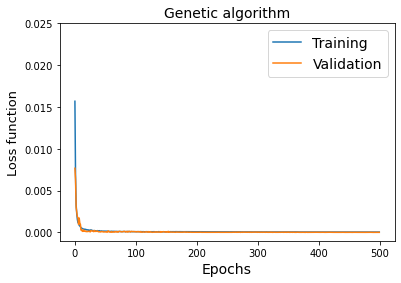

In [21]:
plt.plot(history_gen3['loss'], label='Training')
plt.plot(history_gen3['val_loss'], label='Validation')
plt.ylabel('Loss function', fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.title("Genetic algorithm", fontsize=14)
plt.ylim(-0.001, 0.025)
plt.savefig("loss_gen_ecs.png")

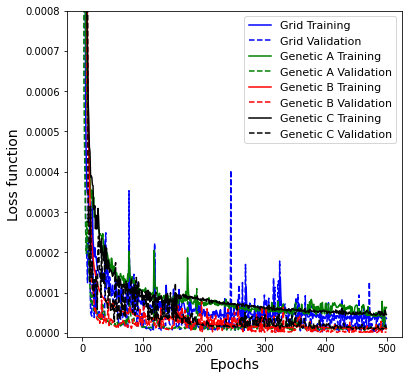

In [30]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.plot(history_grid['loss'], label='Grid Training', color='blue')
plt.plot(history_grid['val_loss'], label='Grid Validation', color='blue', linestyle='dashed')
plt.plot(history_gen1['loss'], label='Genetic A Training', color='green')
plt.plot(history_gen1['val_loss'], label='Genetic A Validation', color='green', linestyle='dashed')
plt.plot(history_gen2['loss'], label='Genetic B Training', color='red')
plt.plot(history_gen2['val_loss'], label='Genetic B Validation', color='red', linestyle='dashed')
plt.plot(history_gen3['loss'], label='Genetic C Training', color='black')
plt.plot(history_gen3['val_loss'], label='Genetic C Validation', color='black', linestyle='dashed')
plt.ylim(-0.00001, 0.0008)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.ylabel('Loss function', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.legend(loc='upper right', fontsize=11)
# plt.title("Genetic algorithm", fontsize=14)
plt.savefig("ecsdiff_loss.png")

In [32]:
model_gen1.save("models/model_ecsdif_genetic.h5")

In [36]:
print("epochs", len(history_gen1['loss']))

epochs 500


In [34]:
loss_gen1, loss_gen2, loss_gen3

(7.983323484950233e-06, 1.5655112974855001e-06, 1.1097125025116839e-05)

2/2 [==============================] - 0s 1ms/step


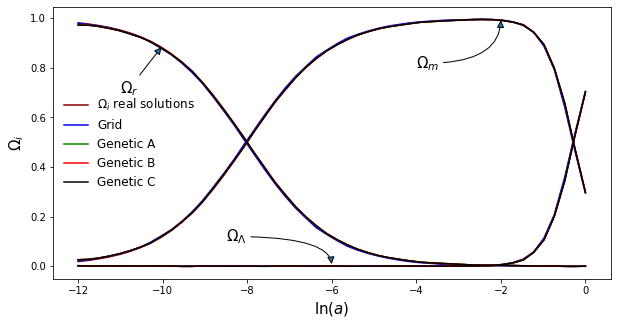

In [38]:
Z=np.linspace(0,-12,50)
dom=[]
dom2=[]
dom3=[]
#different combinations for the params

for z in Z: dom.append([z,0.5,80]) 
# A=model.predict(dom)               
# # ¡¡¡ The inverse transformation must be applied in order to return the labels to their original ranges!!!
# A=scaler.inverse_transform(A) 

for z in Z: dom2.append([z,0.3,70]) 
B_grid=model_grid.predict(dom2)
B_grid=scaler.inverse_transform(B_grid)

B_gen1=model_gen1.predict(dom2)
B_gen1=scaler.inverse_transform(B_gen1)

B_gen2=model_gen1.predict(dom2)
B_gen2=scaler.inverse_transform(B_gen2)


B_gen3=model_gen1.predict(dom2)
B_gen3=scaler.inverse_transform(B_gen3)


for z in Z: dom3.append([z,0.4,67]) 
C_grid=model_grid.predict(dom3)
C_grid=scaler.inverse_transform(C_grid)
C_gen1=model_gen1.predict(dom3)
C_gen1=scaler.inverse_transform(C_gen1)
C_gen2=model_gen2.predict(dom3)
C_gen2=scaler.inverse_transform(C_gen2)
C_gen3=model_gen3.predict(dom3)
C_gen3=scaler.inverse_transform(C_gen3)
#función real
D=EDO(Z, 0.3,70)

plt.figure(figsize=(10,5))

plt.plot(Z,D[:,0],color='darkred')
plt.plot(Z,D[:,1],color='darkred')
plt.plot(Z,D[:,2],color='darkred', label='$\Omega_i$ real solutions')

#Realvs model
plt.plot(Z,B_grid[:,0],color='blue')
plt.plot(Z,B_grid[:,1],color='blue')
plt.plot(Z,B_grid[:,2],color='blue', label='Grid')
#plt.plot(Z,B[:,3])

plt.plot(Z,B_gen1[:,0],color='green')
plt.plot(Z,B_gen1[:,1],color='green')
plt.plot(Z,B_gen1[:,2],color='green', label='Genetic A')
#plt.plot(Z,B[:,3])
plt.plot(Z,B_gen2[:,0],color='red')
plt.plot(Z,B_gen2[:,1],color='red')
plt.plot(Z,B_gen2[:,2],color='red', label='Genetic B')

plt.plot(Z,B_gen3[:,0],color='black')
plt.plot(Z,B_gen3[:,1],color='black')
plt.plot(Z,B_gen3[:,2],color='black', label='Genetic C')

#plt.plot(Z,D[:,3])

#plt.title()
plt.xlabel('$\ln(a)$', size=15)
plt.ylabel('$\Omega_i$', size=15)
# plt.grid()
plt.legend(fontsize=12, loc='center left', framealpha=0.01)

plt.annotate('$\Omega_m$', xy=(-2,1), xytext=(-4,0.8), size=15,
           arrowprops=dict(arrowstyle='-|>', connectionstyle="angle3,angleA=0,angleB=-90"))

plt.annotate('$\Omega_r$', xy=(-10,0.89), xytext=(-11,0.7),size=15,
           arrowprops=dict(arrowstyle='-|>'))

plt.annotate('$\Omega_{\Lambda}$', xy=(-6,0), xytext=(-8.5,0.1),size=15,
           arrowprops=dict(arrowstyle='-|>', connectionstyle="angle3,angleA=0,angleB=90"))

#plt.savefig('red_vs_sol.pdf')
# plt.yscale('log')
plt.savefig('ecs_dif.png')

In [39]:
model_gen1.save("models/model_ecsdif_gen1.h5")
model_gen2.save("models/model_ecsdif_gen2.h5")
model_gen3.save("models/model_ecsdif_gen3.h5")